
# 주제 : Seq2Seq의 Encoder로 뉴스기사 토픽 예측하기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제는 뉴스기사 데이터는 reuters Dataset을 사용합니다.
    - reuters Dataset은 11,228개의 뉴스기사와 46개의 주제를 가지고 있습니다.
    - 모든 단어는 빈도에 따른 정수로 교체 되어있습니다.
    - 관례적으로 정수 0은 특정 단어를 나타내는 것으로 사용하지 않습니다.
    - 학습 데이터와 정답 데이터는, 각각의 아래와 같습니다.
    
    1. train_text
      [
        [1,20, 432, 12, 312, ...],
        [42, 21, 111, 1213, ...],
        ...
      ]
    
    2. train_answer
      [
         3,  4,  3, ..., 25,  3
      ]

    
- 데이터 출처: [reuters](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection)


## 최종 목표
    - Seq2Seq 기반 모델의 이해
    - word embedding 이해
    - 시계열 데이터 학습 이해
    
  - 출제자 : 손근영 강사


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 도입전 기본 처리

### 문제 1. reuters 데이터 살펴보기

In [2]:
# 데이터를 불러오는 코드를 작성해주세요.
reuters = keras.datasets.reuters
(train_text, train_topic), (test_text, test_topic) = reuters.load_data()

### 문제 2. train_text/topic와 test_text/topic의 shape을 출력해보세요.

In [3]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.
print(train_text.shape, train_topic.shape)
print(test_text.shape, test_topic.shape)

(8982,) (8982,)
(2246,) (2246,)


In [4]:
# train_text/topic의 dtype을 출력해보세요.
print(train_text.dtype, train_topic.dtype)
print(test_text.dtype, test_topic.dtype)

object int64
object int64


### 문제 3. train_text에서 각 원소의 길이를 y축으로 bar plot를 그려보세요.

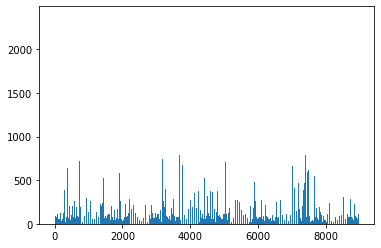

In [5]:
# train_text에서 각 원소의 길이를 y축으로 bar plot를 그려보세요.
plt.bar( range(len(train_text)), [len(text) for text in train_text] )
plt.show()

## Step 2. 전처리

### 문제 4. train_text, test_text에서 등장한 정수들을 알아보자

In [6]:
# train_text, test_text에서 등장한 정수들을 알아보자
all_words = set([word for text in train_text for word in text]) | set([word for text in test_text for word in text])
print( sorted(all_words)[:5] )
print( sorted(all_words)[-5:] )

[1, 2, 4, 5, 6]
[30977, 30978, 30979, 30980, 30981]


### 문제 5. train_text와 test_text를 BOW 형태로 변경

In [7]:
# train_text와 test_text를 BOW 형태로 변경하세요.
train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_text, value = 0) # value = 0 빈 값
test_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_text, value = 0)

In [8]:
print(train_bow_text.shape)
print(test_bow_text.shape)

(8982, 2376)
(2246, 1032)


### 문제 6. train과 test에 나온 word들의 count를 측정해보자

In [9]:
from collections import Counter

In [10]:
# train과 test에 나온 word들의 count를 측정해보자
word_count = Counter()
for text in train_text:
    word_count.update(text)
for text in test_text:
    word_count.update(text)
    
print(word_count.most_common(10))

[(4, 82723), (5, 42393), (6, 40350), (7, 33157), (8, 29978), (9, 29956), (10, 29581), (11, 20141), (12, 16668), (13, 15224)]


### 문제 7. word_count를 이용해서 n번 미만으로 나온 word를 삭제하여 train과 test를 구성하여보자.

In [11]:
# word_count를 이용해서 n번 미만으로 나온 word를 삭제하여 train과 test를 구성하여보자.
def cut_bv_count(texts, n):
    return np.array([[word for word in text if word_count[word] >= n] for text in texts])

In [12]:
train_cut_text = cut_bv_count(train_text, 20)
test_cut_text = cut_bv_count(test_text, 20)

In [13]:
# 단어가 사라진거지 배치가 사라진건 아님
print(train_cut_text.shape) 
print(test_cut_text.shape)

(8982,)
(2246,)


### 문제 8. pad 추가된 bow 형태로 변화하여 width 길이를 확인해보세요.

In [14]:
# bow 형태로 변화하여 width 길이를 확인해보세요.
train_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text, value = 0)
test_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text, value = 0)

In [15]:
print(train_cut_bow_text.shape, test_cut_bow_text.shape)

(8982, 2266) (2246, 995)


### 문제 9. train_text/test_text에 길이 제한을 줘서 bow를 생성해보세요.

In [16]:
# train_text/test_text에 길이 제한을 줘서 bow를 생성해보세요.
train_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(train_text, value = 0, maxlen = 200)
test_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(test_text, value = 0, maxlen = 200)

In [17]:
print(train_cut_bow_text2.shape, test_cut_bow_text2.shape)

(8982, 200) (2246, 200)


### 문제 10. topic을 onehot encoding으로 변경해보세요.

In [18]:
# topic을 onehot encoding으로 변경해보세요.
# np.unique(train_topic) # 45
train_onehot_topic = keras.utils.to_categorical(train_topic)
test_onehot_topic = keras.utils.to_categorical(test_topic)

In [19]:
print(train_onehot_topic.shape, test_onehot_topic.shape)

(8982, 46) (2246, 46)


### 문제 11. topic 인덱스를 text label로 변환하는 함수를 만드세요.

In [20]:
#topic 인덱스를 text label로 변환하는 함수를 만드세요.
raw_labels = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [21]:
def topic2label(idx):
    return raw_labels[idx]

In [22]:
print( topic2label(0) )
print( topic2label(45))

cocoa
lead


## Step 3. 시각화 방법

### 문제 12. train_text의 길이 분포를 출력해보세요.

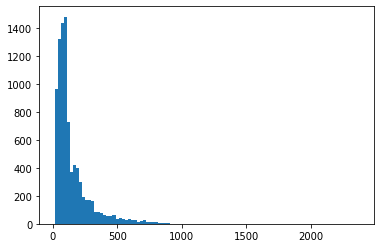

In [23]:
# train_bow_text의 길이 분포를 출력해보세요.
plt.hist( [len(s) for s in train_text], bins=100 )
plt.show()

### 문제 13. train_cut_bow_text의 길이 분포를 출력해보세요.

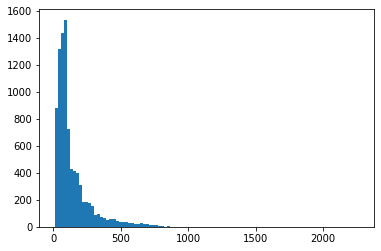

In [24]:
# train_bow_text의 길이 분포를 출력해보세요.
plt.hist( [len(s) for s in train_cut_text], bins=100 )
plt.show()

### 문제 14. train_cut_bow_text2의 길이 분포를 출력해보세요.

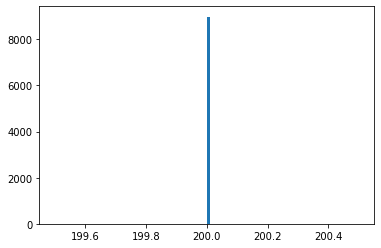

In [25]:
# train_cut_bow_text2의 길이 분포를 출력해보세요.
plt.hist( [len(s) for s in train_cut_bow_text2], bins=100)
plt.show()

### 문제 15. label 분포를 출력해보세요.

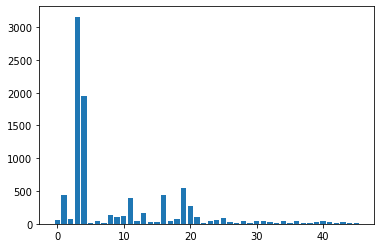

In [26]:
# label 분포를 출력해보세요.
plt.bar( np.unique(train_topic),list(map(lambda x:x[1], sorted(Counter(train_topic).items()))) )
plt.show()

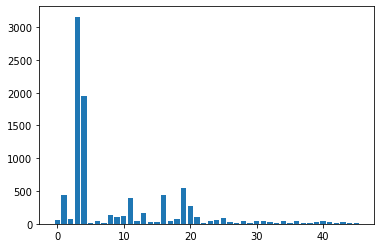

In [27]:
plt.bar( *np.unique(train_topic, return_counts=True) )
plt.show()

### 문제 16. seabon을 이용하여 label 분포를 출력해보세요.

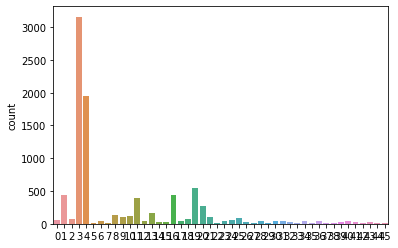

In [28]:
# label 분포를 출력해보세요.
sns.countplot(train_topic)
plt.show()

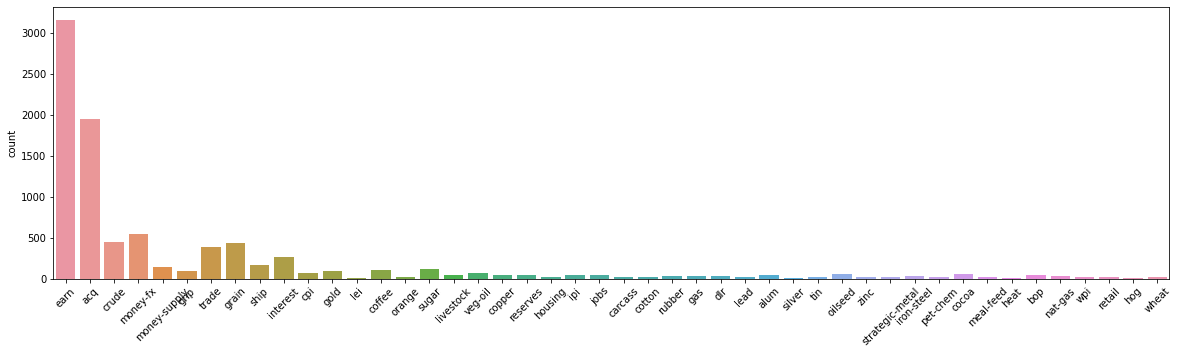

In [29]:
sns.countplot( list(map(lambda x: topic2label(x), train_topic)) )
plt.xticks(rotation=45)
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.show()

### 문제 17. reuters.get_word_index()를 이용해서 text를 decode해보세요.

In [30]:
# reuters.get_word_index()를 이용해서 text를 decode해보세요.
index_word = { y:x for x,y in reuters.get_word_index().items() }
def bow2text(bow):
    return ' '.join([index_word[idx] for idx in bow])

In [31]:
print( bow2text(train_text[0]) )

the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs


### 문제 18. train/test 데이터에서 문서당 가장 많은 횟수로 출현한 word 분포를 출력하세요.

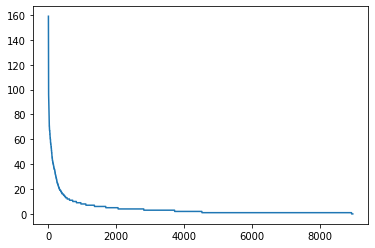

In [32]:
# 문서당 가장 많은 횟수로 출현한 word 분포를 출력하세요.
plt.plot( sorted( [np.unique(doc, return_counts=True)[1].argmax() for doc in train_text], reverse=True) )
plt.show()

### 문제 19. train/test 전체 문서 당 출현이 가장 높은 word 분포를 출력하세요.

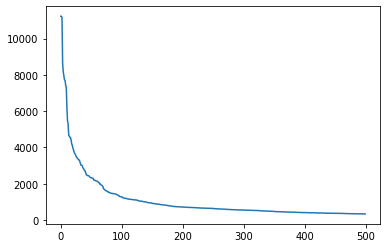

In [33]:
# train/test 전체 문서 당 출현이 가장 높은 word 분포를 출력하세요.
table = np.zeros(len(all_words) + 2)
for doc in train_text:
    table[np.unique(doc)] += 1
for doc in test_text:
    table[np.unique(doc)] += 1
plt.plot(sorted(table, reverse=True)[:500])
plt.show()

## Step 4. Seq2Seq의 Encoder 이용 모델링

### 문제 20. Encoder이용 classification 모델 구축

In [34]:
# seq2seq 모델을 구축하고 학습모델, encoder를 획득하세요
from keras.layers import Input, Embedding, GRU, Dense
from keras.models import Model

def seq2seq():
    inputs_x_bow = Input(shape=(200,))
    embedding = Embedding(len(index_word)+1, 120) # bow를 dense하게
    x = embedding(inputs_x_bow)
    z = GRU(64)(x) # Context vector return
    y = Dense(46, activation='softmax')(z)
    
    model = Model(inputs_x_bow, y)
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

### 문제 21. 학습 모델을 생성하고 summary를 출력하세요. 

In [35]:
# 학습 모델을 생성하고 summary를 출력하세요.
model = seq2seq()

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 120)          3717600   
_________________________________________________________________
gru (GRU)                    (None, 64)                35712     
_________________________________________________________________
dense (Dense)                (None, 46)                2990      
Total params: 3,756,302
Trainable params: 3,756,302
Non-trainable params: 0
_________________________________________________________________


### 문제 22. 모델을 학습해보세요.

In [75]:
# 학습모델을 학습해보세요.
hist = model.fit(
    x = train_cut_bow_text2,
    y = train_onehot_topic,
    validation_data = (test_cut_bow_text2, test_onehot_topic),
    verbose = 1,
    epochs =20
)

Epoch 1/20
281/281 [==============================] - 6s 23ms/step - loss: 0.0801 - acc: 0.9554 - val_loss: 2.2196 - val_acc: 0.6687
Epoch 2/20
281/281 [==============================] - 6s 23ms/step - loss: 0.0796 - acc: 0.9539 - val_loss: 2.2329 - val_acc: 0.6710
Epoch 3/20
281/281 [==============================] - 7s 23ms/step - loss: 0.0769 - acc: 0.9535 - val_loss: 2.2731 - val_acc: 0.6612
Epoch 4/20
281/281 [==============================] - 7s 26ms/step - loss: 0.0780 - acc: 0.9558 - val_loss: 2.2986 - val_acc: 0.6523
Epoch 5/20
281/281 [==============================] - 7s 24ms/step - loss: 0.0827 - acc: 0.9544 - val_loss: 2.2878 - val_acc: 0.6656
Epoch 6/20
281/281 [==============================] - 7s 25ms/step - loss: 0.0767 - acc: 0.9554 - val_loss: 2.3215 - val_acc: 0.6585
Epoch 7/20
281/281 [==============================] - 7s 25ms/step - loss: 0.0741 - acc: 0.9554 - val_loss: 2.3093 - val_acc: 0.6674
Epoch 8/20
281/281 [==============================] - 7s 25ms/step - 

### 문제 23. 학습 진행 사항을 plt으로 출력하세요.

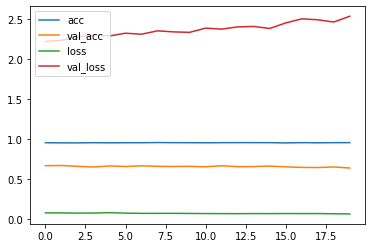

In [76]:
# hist의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot( hist.history['acc'], label='acc')
plt.plot( hist.history['val_acc'], label='val_acc')
plt.plot( hist.history['loss'], label='loss')
plt.plot( hist.history['val_loss'], label='val_loss')
plt.legend(loc = 'upper left')
plt.show()

### 문제 24. train_cut_bow_text를 위한 학습 모델을 생성하고 summary를 출력하세요. 

In [58]:
# 학습 모델을 생성하고 summary를 출력하세요.
model2 = seq2seq()
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 120)          3717600   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                35712     
_________________________________________________________________
dense_1 (Dense)              (None, 46)                2990      
Total params: 3,756,302
Trainable params: 3,756,302
Non-trainable params: 0
_________________________________________________________________


### 문제 25. 학습모델을 학습해보세요. 단, train_cut_bow_text를 200으로 길이를 수정하고 실행하세요.

In [61]:
# 학습모델을 학습해보세요.
hist2 = model2.fit(
    train_cut_bow_text[..., -200:],
    train_onehot_topic,
    validation_data= (test_cut_bow_text[..., -200:], test_onehot_topic),
    verbose = 1,
    epochs = 20
)

Epoch 1/20
281/281 [==============================] - 9s 28ms/step - loss: 2.6223 - acc: 0.3530 - val_loss: 1.8497 - val_acc: 0.5093
Epoch 2/20
281/281 [==============================] - 8s 27ms/step - loss: 1.6854 - acc: 0.5494 - val_loss: 1.6504 - val_acc: 0.5922
Epoch 3/20
281/281 [==============================] - 8s 27ms/step - loss: 1.5306 - acc: 0.6163 - val_loss: 1.5673 - val_acc: 0.6091
Epoch 4/20
281/281 [==============================] - 8s 27ms/step - loss: 1.3623 - acc: 0.6570 - val_loss: 1.4854 - val_acc: 0.6282
Epoch 5/20
281/281 [==============================] - 8s 27ms/step - loss: 1.1617 - acc: 0.7053 - val_loss: 1.4196 - val_acc: 0.6425
Epoch 6/20
281/281 [==============================] - 8s 27ms/step - loss: 1.0153 - acc: 0.7480 - val_loss: 1.3607 - val_acc: 0.6603
Epoch 7/20
281/281 [==============================] - 8s 27ms/step - loss: 0.8520 - acc: 0.7876 - val_loss: 1.3581 - val_acc: 0.6790
Epoch 8/20
281/281 [==============================] - 7s 27ms/step - 

### 문제 26. 학습 진행 사항을 plt으로 출력하세요.

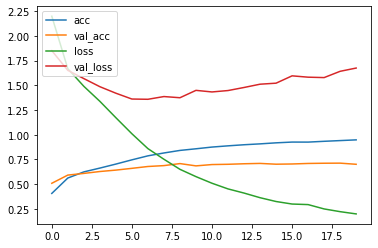

In [62]:
# hist2의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot( hist2.history['acc'], label='acc')
plt.plot( hist2.history['val_acc'], label='val_acc')
plt.plot( hist2.history['loss'], label='loss')
plt.plot( hist2.history['val_loss'], label='val_loss')
plt.legend(loc = 'upper left')
plt.show()

## Step 5. 모델 결과 확인

### 문제 27. 완성된 모델1, 2에서 test 하나를 예측하고 결과를 res1, res2 변수에 저정하세요.

In [63]:
# 완성된 모델에서 test 하나를 예측하고 결과를 res 변수에 저정하세요.
res1 = model.predict(test_cut_bow_text2[0:1])
print(res1.shape)

(1, 46)


In [65]:
res2 = model2.predict(test_cut_bow_text[0:1, -200:])
print(res2.shape)

(1, 46)


In [69]:
print(res1[0])
print(res2[0])

[2.51905896e-09 2.81158318e-05 6.28179686e-09 2.94279866e-03
 9.95745003e-01 7.57289058e-08 1.11754363e-10 6.08696791e-06
 9.38088215e-06 3.12405435e-09 1.58518505e-05 3.65932465e-05
 1.96270976e-05 9.36701117e-09 2.01694775e-06 5.42155931e-10
 1.29489008e-05 1.04624211e-04 9.73725264e-07 5.50680579e-06
 1.27567455e-05 2.88724405e-04 5.50551027e-09 1.25752103e-05
 4.25630697e-10 8.76263714e-11 3.06855071e-07 4.60651052e-07
 5.32092294e-04 4.02117666e-06 2.22441922e-05 4.74704507e-08
 3.57335637e-07 1.34710845e-07 6.80574530e-08 7.10635213e-05
 9.85204679e-06 4.04702583e-08 4.03476915e-05 7.28257291e-05
 1.17730909e-08 2.28559043e-06 9.52090518e-10 6.26310914e-09
 2.72771614e-11 5.64445279e-12]
[3.41829844e-04 2.46406831e-02 1.91844288e-06 7.65589595e-01
 9.32549089e-02 2.58968157e-06 8.54914106e-06 1.24086131e-04
 4.16896120e-03 4.20490192e-04 3.28190275e-03 1.27068637e-02
 8.88589071e-04 1.87041423e-05 7.95300082e-07 4.30943743e-08
 2.07401090e-03 1.96095032e-04 7.29283897e-07 7.31047

### 문제 28. res1, res2의 결과를 확인하세요.

acq earn


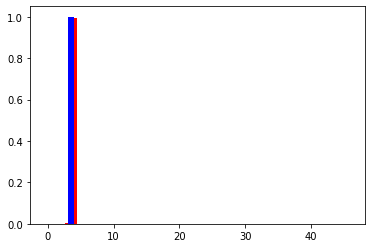

In [77]:
# res1, res2의 결과를 확인하세요.
plt.bar( np.array(range(len(res1[0]))), res1[0], color='red')
plt.bar( np.array(range(len(res1[0])))+0.5, test_onehot_topic[0], color='blue')


print( topic2label(res1[0].argmax()),topic2label(test_onehot_topic[0].argmax() ))

earn earn


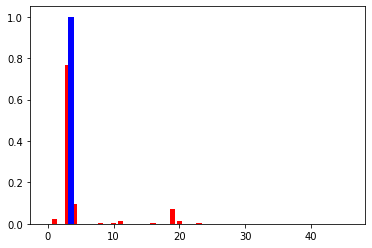

In [74]:
plt.bar( np.array(range(len(res2[0]))), res2[0], color='red')
plt.bar( np.array(range(len(res2[0])))+0.5, test_onehot_topic[0], color='blue')

print( topic2label(res2[0].argmax()),topic2label(test_onehot_topic[0].argmax() ))

### 문제 29. reuters.get_word_index()를 이용하여 평문을 bow로 변환해보세요. 

In [104]:
# reuters.get_word_index()를 이용하여 평문을 bow로 변환해보세요. (oov는 무시합니다.)
txt = bow2text(test_text[0])
def text2bow(text, maxlen=400):
    word_index = reuters.get_word_index()
    seq = np.array([word_index[word] for word in text.lower().replace('\n', ' ').split() if word in word_index])
    bow = tf.keras.preprocessing.sequence.pad_sequences([seq], value=0, maxlen=maxlen)
    return bow

In [105]:
bow1 = text2bow(txt)
print(bow1[..., -200:], bow1.shape, sep='\n')

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     1     4  1378  2025     9
    697  4622   111     8    25   109    29  3650    11   150   244   364
     33    30    30  1398   333     6 18292   159     9  1084   363    13
  19231    71     9 16273    71   117     4   225    78   206    10     9
   1214     8     4   270     5 16273     7   748    48     9 19231     7
    207  1451   966  1864   793    97   133   336     7     4   493    98
    273   104   284    25    39   338    22   905   220  3465   644    59
     20     6   119    61    11    15    58   579    26    10    67     7
      4   738    98    43    88   333   722    12    20     6    19   746
     35    15    10     9  1214   855 

### 문제 30. text2bow를 이용하여 model1을 통해 결과를 확인하세요.

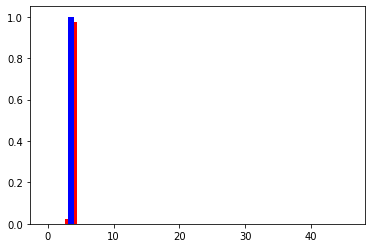

acq earn


In [113]:
# text2bow를 이용하여 model1을 통해 결과를 확인하세요.
res3 = model.predict(bow1[..., -200:])
plt.bar( np.array(range(len(res3[0]))), res3[0], color='red')
plt.bar( np.array(range(len(res3[0])))+0.5, test_onehot_topic[0], color='blue')
plt.show()

print(topic2label(res3[0].argmax()), topic2label(test_topic[0]))

### 문제 31. cut_by_count를 이용하여 20회 이상 등장한 word만 사용하는 bow를 만들어보세요

In [114]:
# cut_by_count를 이용하여 20회 이상 등장한 word만 사용하는 bow를 만들어보세요
# cut_bv_count(bow1, 20).shape # (1, 362)
bow1_cut = tf.keras.preprocessing.sequence.pad_sequences(cut_bv_count(bow1, 20), maxlen= 200) # (1, 200)

### 문제 32. text2bow를 이용하여 model1을 통해 결과를 확인하세요.


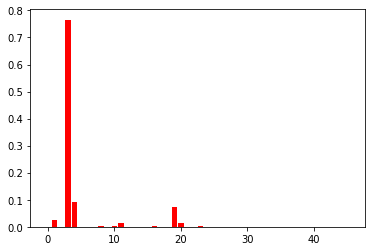

earn earn


In [115]:
#text2bow를 이용하여 model1을 통해 결과를 확인하세요.
res4 = model2.predict(bow1_cut)
plt.bar( np.array(range(len(res4[0]))), res4[0], color='red')
plt.show()
print(topic2label(res4[0].argmax()), topic2label(test_topic[0]))

### 문제 33. confusion 매트릭스 생성

In [128]:
# confusion 메트릭스 출력
from sklearn.metrics import confusion_matrix
conf_mat1 = confusion_matrix(test_topic, model.predict(test_cut_bow_text2).argmax(axis=1))
conf_mat2 = confusion_matrix(test_topic, model2.predict(test_cut_bow_text[...,-200:]).argmax(axis=1))
print(conf_mat1.shape, conf_mat2.shape)
print(conf_mat1)
print(conf_mat2)

(46, 46) (46, 46)
[[ 8  0  0 ...  0  0  0]
 [ 0 72  1 ...  0  0  0]
 [ 0  5 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]
[[ 7  1  0 ...  0  0  0]
 [ 0 71  1 ...  0  0  0]
 [ 0  2  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  0]]


### 문제 34. confusion 매트릭스 시각화

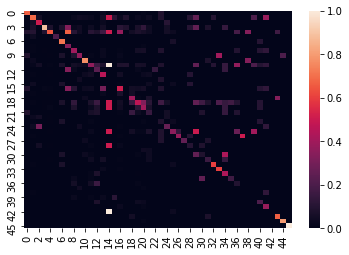

In [130]:
# confusion 매트릭스 시각화
sns.heatmap(conf_mat1 / conf_mat1.sum(axis=1))
plt.show()

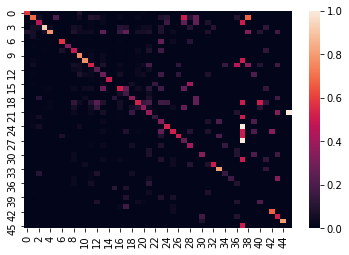

In [131]:
sns.heatmap(conf_mat2 / conf_mat2.sum(axis=1))
plt.show()

### 문제 35. classification 결과 리포팅

In [134]:
# classification 결과 리포팅
from sklearn.metrics import classification_report
report1 = classification_report(test_topic, model.predict(test_cut_bow_text2).argmax(axis=1), target_names=raw_labels)
report2 = classification_report(test_topic, model2.predict(test_cut_bow_text[...,-200:]).argmax(axis=1), target_names=raw_labels)

In [135]:
print(report1)

                 precision    recall  f1-score   support

          cocoa       0.67      0.67      0.67        12
          grain       0.59      0.69      0.63       105
        veg-oil       0.50      0.50      0.50        20
           earn       0.86      0.89      0.87       813
            acq       0.79      0.65      0.71       474
          wheat       1.00      0.20      0.33         5
         copper       0.56      0.71      0.63        14
        housing       0.17      0.33      0.22         3
   money-supply       0.35      0.39      0.37        38
         coffee       0.56      0.36      0.44        25
          sugar       0.77      0.77      0.77        30
          trade       0.37      0.36      0.36        83
       reserves       0.21      0.23      0.22        13
           ship       0.34      0.46      0.39        37
         cotton       0.00      0.00      0.00         2
        carcass       0.00      0.00      0.00         9
          crude       0.34    

In [136]:
print(report2)

                 precision    recall  f1-score   support

          cocoa       0.88      0.58      0.70        12
          grain       0.67      0.68      0.67       105
        veg-oil       0.53      0.45      0.49        20
           earn       0.89      0.93      0.91       813
            acq       0.84      0.78      0.81       474
          wheat       0.00      0.00      0.00         5
         copper       0.80      0.57      0.67        14
        housing       1.00      0.33      0.50         3
   money-supply       0.46      0.47      0.47        38
         coffee       0.63      0.76      0.69        25
          sugar       0.82      0.77      0.79        30
          trade       0.49      0.53      0.51        83
       reserves       0.27      0.23      0.25        13
           ship       0.22      0.27      0.24        37
         cotton       1.00      0.50      0.67         2
        carcass       0.00      0.00      0.00         9
          crude       0.46    

## Step 6. 모델 저장 및 로드, 다운

### 문제 36. 모델을 저장하세요.

In [137]:
# 모델을 저장하는 코드를 작성하세요. 
model.save('./lecture10.h5')

### 문제 37. 모델 파일을 새로운 모델에 로드하세요.

In [138]:
# 모델을 로드하는 코드를 작성하세요.
new_model = tf.keras.models.load_model('./lecture10.h5')
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 120)          3717600   
_________________________________________________________________
gru (GRU)                    (None, 64)                35712     
_________________________________________________________________
dense (Dense)                (None, 46)                2990      
Total params: 3,756,302
Trainable params: 3,756,302
Non-trainable params: 0
_________________________________________________________________


### 문제 38. 로드한 모델을 test 데이터로 평가해보세요.


In [140]:
# 로드한 모델을 test 데이터로 평가해보세요.
loss, acc = new_model.evaluate(test_cut_bow_text2, test_onehot_topic, verbose=1)
print(loss, acc)

71/71 [==============================] - 1s 5ms/step - loss: 2.5332 - acc: 0.6394
2.533216714859009 0.6393588781356812


### 문제 39. 모델을 내 컴퓨터에 저장해보세요

In [54]:
# 모델을 내 컴퓨터에 저장해보세요.